<a href="https://colab.research.google.com/github/Satyamdevloper25/Card/blob/main/flux.1-dev_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

!pip install -q torchsde einops diffusers accelerate xformers==0.0.28.post2
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

/content
fatal: destination path '/content/TotoroUI' already exists and is not an empty directory.
/content/TotoroUI
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.5.0 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.5.0 which is incompatible.
aria2 is already the newest version (1.36.0-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
53393b|OK  |       0B/s|/content/TotoroUI/models/unet/flux1-dev-fp8.safetensors

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
d4116b|OK  |       0B

    PyTorch 2.5.0+cu121 with CUDA 1201 (you have 2.6.0+cu124)
    Python  3.11.10 (you have 3.11.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [1]:
import torch
import torchvision

print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)


Torch: 2.6.0+cu124
Torchvision: 0.21.0+cu124


In [4]:
!pip install torch==2.6.0 --extra-index-url https://download.pytorch.org/whl/cu124 -U


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124
  Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl.metadata (28 kB)
Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl (768.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.7/166.7 MB 6.5 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
  Attempting uninstall: torch
    Found existing installation: torch 2.5.0
    Uninstalling torch-2.5.0:
      Successfully uninstalled torch-2.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.28.post2 requires torch==2.5.0, but you have torch 2.6.0+cu124 which is incompatible.


12025524713307394874


  0%|          | 0/20 [00:00<?, ?it/s]

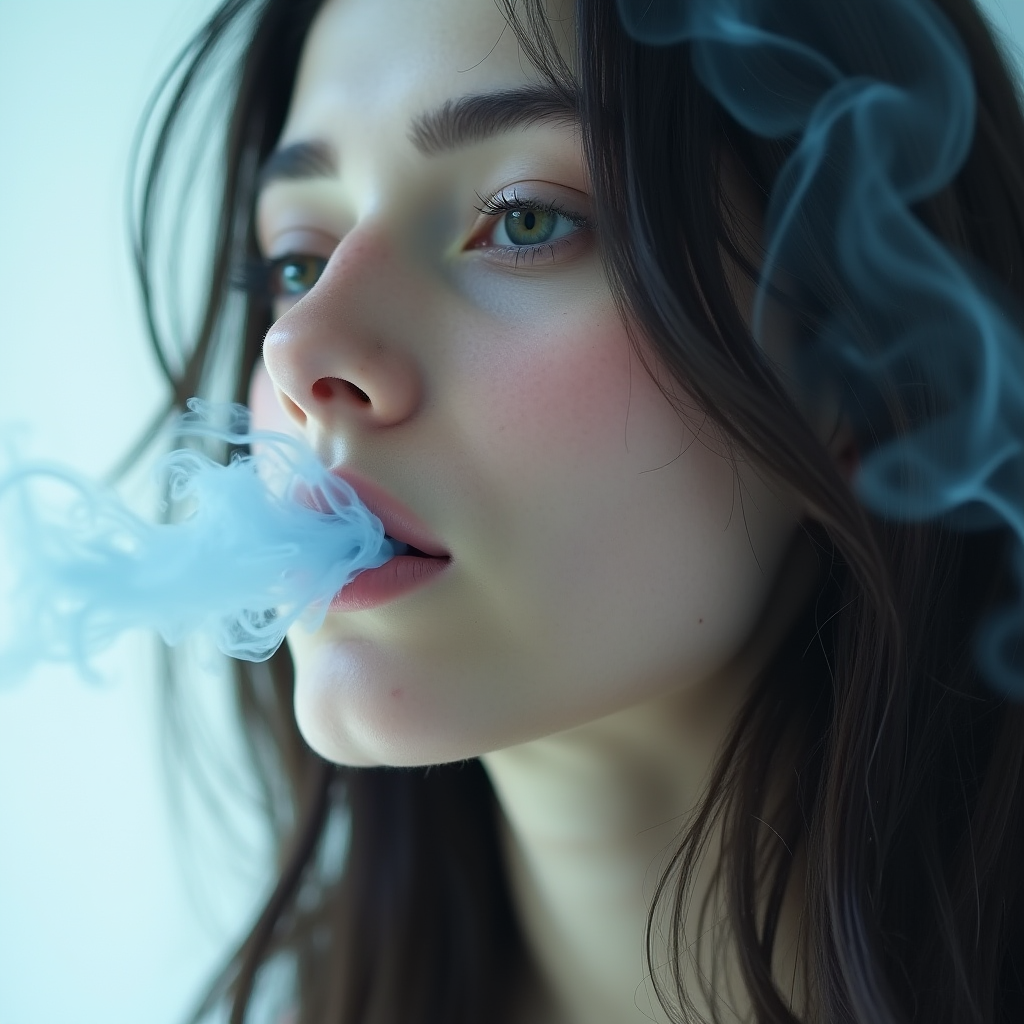

In [5]:
with torch.inference_mode():
    positive_prompt = "close-up of a young woman with pale blue smoke curling from her lips against a stark white background, her features emphasized by soft lighting that casts gentle shadows, capturing a moment of quiet solitude and introspection, her dark hair contrasting with the lightness of the smoke and her surroundings --ar 9:16 --style raw --v 6"
    width = 1024
    height = 1024
    seed = 0
    steps = 20
    sampler_name = "euler"
    scheduler = "simple"

    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(seed)

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    noise = RandomNoise.get_noise(seed)[0]
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
    latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])